# Overview
The notebook aims to get a better feeling for the data and more importantly the distributions of values. We take the labels and combine them with the detailed class info and try and determine what the biggest challenges of the prediction might be. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle
det_class_path = '../input/stage_1_detailed_class_info.csv'
bbox_path = '../input/stage_1_train_labels.csv'
dicom_dir = '../input/stage_1_train_images/'

# Detailed Class Info
Here we show the image-level labels for the scans. The most interesting group here is the `No Lung Opacity / Not Normal` since they are cases that look like opacity but are not. So the first step might be to divide the test images into clear groups and then only perform the bounding box prediction on the suspicious images.

28989 class infos loaded
25684 patient cases


,patientId,class
6563,4fd82276-a900-49e3-8282-ffda6edd6068,Lung Opacity
22025,c78daf52-c33b-4367-a28f-5bc60a92e7d9,Lung Opacity
16237,9d7122f2-9b37-41cb-92f5-b4954ba23b6c,No Lung Opacity / Not Normal


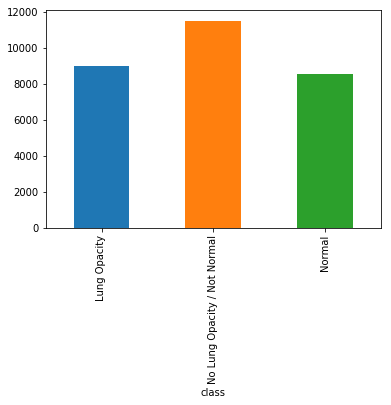

In [2]:
det_class_df = pd.read_csv(det_class_path)
print(det_class_df.shape[0], 'class infos loaded')
print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')
det_class_df.groupby('class').size().plot.bar()
det_class_df.sample(3)

# Load the Bounding Box Data
Here we show the bounding boxes

In [3]:
bbox_df = pd.read_csv(bbox_path)
print(bbox_df.shape[0], 'boxes loaded')
print(bbox_df['patientId'].value_counts().shape[0], 'patient cases')
bbox_df.sample(3)

28989 boxes loaded
25684 patient cases


,patientId,x,y,width,height,Target
14862,9213259c-2814-4cbb-98a8-b4a21bfdf6ae,NaN,NaN,NaN,NaN,0
24109,d8cd7100-a106-41c7-9aa2-d1b88b789bba,NaN,NaN,NaN,NaN,0
20672,bca2c151-2431-4595-80c7-75480a196c6e,328.0,415.0,129.0,226.0,1


# Combine Boxes and Labels
Here we bring the labels and the boxes together and now we can focus on how the boxes look on the images

In [4]:
# we first try a join and see that it doesn't work (we end up with too many boxes)
comb_bbox_df = pd.merge(bbox_df, det_class_df, how='inner', on='patientId')
print(comb_bbox_df.shape[0], 'combined cases')

35875 combined cases


## Concatenate
We have to concatenate the two datasets and then we get class and target information on each region

In [5]:
comb_bbox_df = pd.concat([bbox_df, 
                        det_class_df.drop('patientId',1)], 1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df.sample(3)

28989 combined cases


,patientId,x,y,width,height,Target,class
10764,719dd825-dd41-46f9-a59c-7385d4576196,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
17858,a9dbe0c0-3f75-4917-b44a-928692f5add0,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
7020,5399e1e3-a2a1-48c3-80ab-29b18ecb98f4,NaN,NaN,NaN,NaN,0,Normal


# Distribution of Boxes and Labels
The values below show the number of boxes and the patients that have that number. 

In [6]:
box_df = comb_bbox_df.groupby('patientId').\
    size().\
    reset_index(name='boxes')
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
box_df.\
    groupby('boxes').\
    size().\
    reset_index(name='patients')

,boxes,patients
0,1,22506
1,2,3062
2,3,105
3,4,11


# How are class and target related?
I assume that all the `Target=1` values fall in the `Lung Opacity` class, but it doesn't hurt to check.

In [7]:
comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,8964
1,No Lung Opacity / Not Normal,0,11500
2,Normal,0,8525


# Images
Now that we have the boxes and labels loaded we can examine a few images.

In [8]:
image_df = pd.DataFrame({'path': glob(os.path.join(dicom_dir, '*.dcm'))})
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print(image_df.shape[0], 'images found')
img_pat_ids = set(image_df['patientId'].values.tolist())
box_pat_ids = set(comb_box_df['patientId'].values.tolist())
# check to make sure there is no funny business
assert img_pat_ids.union(box_pat_ids)==img_pat_ids, "Patient IDs should be the same"

25684 images found


# Enrich the image fields
We have quite a bit of additional data in the DICOM header we can easily extract to help learn more about the patient like their age, view position and gender which can make the model much more precise

In [9]:
DCM_TAG_LIST = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex']
def get_tags(in_path):
    c_dicom = pydicom.read_file(in_path, stop_before_pixels=True)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
         for c_tag in DCM_TAG_LIST}
    tag_dict['path'] = in_path
    return pd.Series(tag_dict)
image_meta_df = image_df.apply(lambda x: get_tags(x['path']), 1)
# show the summary
image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)
image_meta_df['PatientAge'].hist()
image_meta_df.drop('path',1).describe(exclude=np.number)

KeyboardInterrupt: 

In [ ]:
image_full_df = pd.merge(image_df,
                         image_meta_df,
                         on='path')
image_bbox_df = pd.merge(comb_box_df, 
                         image_full_df, 
                         on='patientId',
                        how='left')
print(image_bbox_df.shape[0], 'image bounding boxes')
image_bbox_df.sample(3)

## Create Sample Data Set
We create a sample dataset covering different cases, and number of boxes

In [ ]:
sample_df = image_bbox_df.\
    groupby(['Target','class', 'boxes']).\
    apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).\
    reset_index(drop=True)
sample_df

## Show the position and bounding box
Here we can see the position (point) and the bounding box for each of the different image types

In [ ]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()

# Bounding Box Distribution
Here we just look at the bounding box distribution to get a better idea how this looks over the whole dataset

In [ ]:
pos_bbox = image_bbox_df.query('Target==1')
pos_bbox.plot.scatter(x='x', y='y')

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.set_xlim(0, 1024)
ax1.set_ylim(0, 1024)
for _, c_row in pos_bbox.sample(1000).iterrows():
    ax1.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                 width=c_row['width'],
                 height=c_row['height'],
                           alpha=5e-3))

# Show the boxes as segmentation
By showing them as segmentations we can get a better probability map for where the opacity regions are most likely to occur

In [ ]:
# Show the boxes themselves
X_STEPS, Y_STEPS = 1024, 1024
xx, yy = np.meshgrid(np.linspace(0, 1024, X_STEPS),
           np.linspace(0, 1024, Y_STEPS), 
           indexing='xy')
prob_image = np.zeros_like(xx)
for _, c_row in pos_bbox.sample(5000).iterrows():
    c_mask = (xx>=c_row['x']) & (xx<=(c_row['x']+c_row['width']))
    c_mask &= (yy>=c_row['y']) & (yy<=c_row['y']+c_row['height'])
    prob_image += c_mask
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(prob_image, cmap='hot')

# Overlay the Probability on a few images
Does the probability we calculate seem to make sense? or have we flipped something somewhere?

In [ ]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_img_arr = pydicom.read_file(c_path).pixel_array
    # overlay
    c_img = plt.cm.gray(c_img_arr)
    c_img += 0.25*plt.cm.hot(prob_image/prob_image.max())
    c_img = np.clip(c_img, 0, 1)
    c_ax.imshow(c_img)
    
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5,
                                fill=False))
        if i==0: c_ax.legend()
fig.savefig('overview.png', figdpi = 600)

### Save the preprocessed results
We can use the preprocessed results with the appropriate DICOM tags to make model training step easier

In [ ]:
image_bbox_df.to_csv('image_bbox_full.csv', index=False)